## Import necessary libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgbm
from catboost import CatBoostRegressor
import time

from math import sqrt
from numpy import loadtxt
from itertools import product
from tqdm import tqdm
from sklearn import preprocessing
from xgboost import plot_tree
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")


from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

pd.set_option('display.max_columns', 500)
pd.set_option("display.max_rows", 60)

# Part2
## Set up some global vars 

In [44]:

# Set seeds and options
np.random.seed(10)
pd.set_option('display.max_rows', 231)
pd.set_option('display.max_columns', 100)

    # Feature engineering list
new_features = []
enable_feature_idea = [True, True, True, True, True, True, True, True, True, True]

    # Some parameters(maybe add more periods, score will be better) [1,2,3,12]
lookback_range = [1,2,3,4,5,6,7]

tqdm.pandas()


## Load data

In [45]:
test_dataset = loadtxt('D:\\all\\test.csv', delimiter="," ,skiprows=1, usecols = (1,2), dtype=int)
testset = pd.DataFrame(test_dataset, columns = ['shop_id', 'item_id'])

trainset = pd.read_csv('trainset_with_grid.csv')
items = pd.read_csv('D:\\all\\items.csv')
#shops = pd.read_csv('data/shops.csv')


    # Only use more recent data
start_month = 0
end_month = 33
#trainset = trainset[[ 'item_id', 'item_category_id', 'date_block_num', 'item_price', 'item_cnt_month']]
trainset = trainset[[ 'shop_id', 'item_id', 'item_category_id', 'date_block_num', 'item_price', 'item_cnt_month']]
trainset = trainset[(trainset.date_block_num >= start_month) & (trainset.date_block_num <= end_month)]


test_dataset = loadtxt('D:\\all\\test.csv', delimiter="," ,skiprows=1, usecols = (1,2), dtype=int)
testset = pd.DataFrame(test_dataset, columns = ['shop_id', 'item_id'])


    # Get item category id into test_df
testset = testset.merge(items[['item_id', 'item_category_id']], on = 'item_id', how = 'left')
testset['date_block_num'] = 34
    # Make testset contains same column as trainset so we can concatenate them row-wise
testset['item_cnt_month'] = -1

train_test_set = pd.concat([trainset, testset], axis = 0) 
train_test_set.head()


,date_block_num,item_category_id,item_cnt_month,item_id,item_price,shop_id
0,0,37,1.0,22154,999.0,59
1,0,37,5.0,22154,999.0,25
2,0,37,1.0,22154,999.0,24
3,0,37,0.0,22154,NaN,19
4,0,37,0.0,22154,NaN,22


## Fix category

In [46]:
item_categories=pd.read_csv('D:\\all\\item_categories.csv')
l_cat = list(item_categories.item_category_name)
l_cat[0] = 'PC Headsets'
for i in range (1,8):
    l_cat[i]="Access"
l_cat[8] = 'Tickets'
l_cat[9] = 'Delivery'
for ind in range(10,18):
    l_cat[ind] = 'Consoles'
for ind in range(18,25):
    l_cat[ind] = 'Console Games'
l_cat[25] = 'Accessories for games'
for ind in range(26,28):
    l_cat[ind] = 'phone games'
for ind in range(28,32):
    l_cat[ind] = 'CD games'
for ind in range(32,37):
    l_cat[ind] = 'Card'
for ind in range(37,43):
    l_cat[ind] = 'Movie'
for ind in range(43,55):
    l_cat[ind] = 'Books'
for ind in range(55,61):
    l_cat[ind] = 'Music'
for ind in range(61,73):
    l_cat[ind] = 'Gifts'
for ind in range(73,79):
    l_cat[ind] = 'Soft'
for ind in range(79,81):
    l_cat[ind] = 'Office'
for ind in range(81,83):
    l_cat[ind] = 'Clean'
l_cat[83] = 'Elements of a food'
lb = preprocessing.LabelEncoder()
item_categories['item_category_id_fix'] = lb.fit_transform(l_cat)
item_categories['item_category_name_fix'] = l_cat
item_categories.head()

,item_category_name,item_category_id,item_category_id_fix,item_category_name_fix
0,PC - Гарнитуры/Наушники,0,14,PC Headsets
1,Аксессуары - PS2,1,0,Access
2,Аксессуары - PS3,2,0,Access
3,Аксессуары - PS4,3,0,Access
4,Аксессуары - PSP,4,0,Access


In [47]:
train_test_set = train_test_set.merge(item_categories[['item_category_id', 'item_category_id_fix']], on = 'item_category_id', how = 'left')
_ = train_test_set.drop(['item_category_id'],axis=1, inplace=True)
train_test_set.rename(columns = {'item_category_id_fix':'item_category_id'}, inplace = True)

_ = item_categories.drop(['item_category_id'],axis=1, inplace=True)
_ = item_categories.drop(['item_category_name'],axis=1, inplace=True)


item_categories.rename(columns = {'item_category_id_fix':'item_category_id'}, inplace = True)
item_categories.rename(columns = {'item_category_name_fix':'item_category_name'}, inplace = True)
item_categories = item_categories.drop_duplicates()
item_categories.index = np.arange(0, len(item_categories))
#train_test_set=train_test_set.drop("item_price", axis=1)
train_test_set.head()

,date_block_num,item_cnt_month,item_id,item_price,shop_id,item_category_id
0,0,1.0,22154,999.0,59,11
1,0,5.0,22154,999.0,25,11
2,0,1.0,22154,999.0,24,11
3,0,0.0,22154,NaN,19,11
4,0,0.0,22154,NaN,22,11


# Idea 0: Add previous shop/item sales as feature (Lag feature)

In [48]:

if enable_feature_idea[0]:
    for diff in tqdm(lookback_range):
        feature_name = 'prev_shopitem_sales_' + str(diff)
        trainset2 = train_test_set.copy()
        trainset2.loc[:, 'date_block_num'] += diff
        trainset2.rename(columns={'item_cnt_month': feature_name}, inplace=True)
        train_test_set = train_test_set.merge(trainset2[['shop_id', 'item_id', 'date_block_num', feature_name]], on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
        train_test_set[feature_name] = train_test_set[feature_name].fillna(0)
        new_features.append(feature_name)
train_test_set.head(3)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:51<00:00,  7.71s/it]


,date_block_num,item_cnt_month,item_id,item_price,shop_id,item_category_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_4,prev_shopitem_sales_5,prev_shopitem_sales_6,prev_shopitem_sales_7
0,0,1.0,22154,999.0,59,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,5.0,22154,999.0,25,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1.0,22154,999.0,24,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Idea 1: Add previous average item sales per period as feature 

In [49]:
if enable_feature_idea[1]:
    groups = train_test_set.groupby(by = ['item_id', 'date_block_num'])
    for diff in tqdm(lookback_range):
        feature_name = 'prev_item_sales_' + str(diff)
        result = groups.agg({'item_cnt_month':'mean'})
        result = result.reset_index()
        result.loc[:, 'date_block_num'] += diff
        result.rename(columns={'item_cnt_month': feature_name}, inplace=True)
        train_test_set = train_test_set.merge(result, on = ['item_id', 'date_block_num'], how = 'left')
        train_test_set[feature_name] = train_test_set[feature_name].fillna(0)
        new_features.append(feature_name)        
train_test_set.head(3)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:22<00:00,  3.30s/it]


,date_block_num,item_cnt_month,item_id,item_price,shop_id,item_category_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_4,prev_shopitem_sales_5,prev_shopitem_sales_6,prev_shopitem_sales_7,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3,prev_item_sales_4,prev_item_sales_5,prev_item_sales_6,prev_item_sales_7
0,0,1.0,22154,999.0,59,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,5.0,22154,999.0,25,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1.0,22154,999.0,24,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Idea 2: Add previous shop/item price as feature (Lag feature)

In [51]:

if enable_feature_idea[3]:
    groups = train_test_set.groupby(by = ['shop_id', 'item_id', 'date_block_num'])
    for diff in tqdm(lookback_range):
        feature_name = 'prev_shopitem_price_' + str(diff)
        result = groups.agg({'item_price':'mean'})
        result = result.reset_index()
        result.loc[:, 'date_block_num'] += diff
        result.rename(columns={'item_price': feature_name}, inplace=True)
        train_test_set = train_test_set.merge(result, on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
        train_test_set[feature_name] = train_test_set[feature_name]
        new_features.append(feature_name)        
train_test_set.head(3)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:33<00:00, 13.50s/it]


,date_block_num,item_cnt_month,item_id,item_price,shop_id,item_category_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_4,prev_shopitem_sales_5,prev_shopitem_sales_6,prev_shopitem_sales_7,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3,prev_item_sales_4,prev_item_sales_5,prev_item_sales_6,prev_item_sales_7,prev_item_price_1,prev_item_price_2,prev_item_price_3,prev_item_price_4,prev_item_price_5,prev_item_price_6,prev_item_price_7,prev_shopitem_price_1,prev_shopitem_price_2,prev_shopitem_price_3,prev_shopitem_price_4,prev_shopitem_price_5,prev_shopitem_price_6,prev_shopitem_price_7
0,0,1.0,22154,999.0,59,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,5.0,22154,999.0,25,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1.0,22154,999.0,24,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Idea 3: Add previous item price as feature (Lag feature)

In [50]:

if enable_feature_idea[3]:
    groups = train_test_set.groupby(by = ['item_id', 'date_block_num'])
    for diff in tqdm(lookback_range):
        feature_name = 'prev_item_price_' + str(diff)
        result = groups.agg({'item_price':'mean'})
        result = result.reset_index()
        result.loc[:, 'date_block_num'] += diff
        result.rename(columns={'item_price': feature_name}, inplace=True)
        train_test_set = train_test_set.merge(result, on = ['item_id', 'date_block_num'], how = 'left')
        train_test_set[feature_name] = train_test_set[feature_name]
        new_features.append(feature_name)        
train_test_set.head(3)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:28<00:00,  4.32s/it]


,date_block_num,item_cnt_month,item_id,item_price,shop_id,item_category_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_4,prev_shopitem_sales_5,prev_shopitem_sales_6,prev_shopitem_sales_7,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3,prev_item_sales_4,prev_item_sales_5,prev_item_sales_6,prev_item_sales_7,prev_item_price_1,prev_item_price_2,prev_item_price_3,prev_item_price_4,prev_item_price_5,prev_item_price_6,prev_item_price_7
0,0,1.0,22154,999.0,59,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,5.0,22154,999.0,25,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1.0,22154,999.0,24,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Idea 4: Mean encodings for shop/item pairs

In [10]:
def create_mean_encodings(train_test_set, categorical_var_list, target):
    feature_name = "_".join(categorical_var_list) + "_" + target + "_mean"

    df = train_test_set.copy()
    df1 = df[df.date_block_num <= 32]
    df2 = df[df.date_block_num <= 33]
    df3 = df[df.date_block_num == 34]

    # Extract mean encodings using training data(here we don't use month 33 to avoid data leak on validation)
    # If I try to extract mean encodings from all months, then val rmse decreases a tiny bit, but test rmse would increase by 4%
    # So this is important
    mean_32 = df1[categorical_var_list + [target]].groupby(categorical_var_list, as_index=False)[[target]].mean()
    mean_32 = mean_32.rename(columns={target:feature_name})

    # Extract mean encodings using all data, this will be applied to test data
    mean_33 = df2[categorical_var_list + [target]].groupby(categorical_var_list, as_index=False)[[target]].mean()
    mean_33 = mean_33.rename(columns={target:feature_name})

    # Apply mean encodings
    df2 = df2.merge(mean_32, on = categorical_var_list, how = 'left')
    df3 = df3.merge(mean_33, on = categorical_var_list, how = 'left')

    # Concatenate
    train_test_set = pd.concat([df2, df3], axis = 0)
    new_features.append(feature_name)
    return train_test_set

In [ ]:
categorical_var_list=['shop_id', 'item_id']
target='item_cnt_month'
feature_name = "_".join(categorical_var_list) + "_" + target + "_mean"

df = train_test_set.copy()
df1 = df[df.date_block_num <= 32]
df2 = df[df.date_block_num <= 33]
df3 = df[df.date_block_num == 34]
mean_32 = df1[categorical_var_list + [target]].groupby(categorical_var_list, as_index=False)[[target]].mean()
mean_32 = mean_32.rename(columns={target:feature_name})

 # Extract mean encodings using all data, this will be applied to test data
mean_33 = df2[categorical_var_list + [target]].groupby(categorical_var_list, as_index=False)[[target]].mean()
mean_33 = mean_33.rename(columns={target:feature_name})
df2 = df2.merge(mean_32, on = categorical_var_list, how = 'left')
df3 = df3.merge(mean_33, on = categorical_var_list, how = 'left')
train_test_set = pd.concat([df2, df3], axis = 0)
new_features.append(feature_name)
train_test_set.head(3)


In [12]:
new_features.pop()

'shop_id_item_id_item_cnt_month_mean'

In [13]:
new_features.remove('shop_id_item_id_item_cnt_month_mean')

In [13]:
new_features

['prev_shopitem_sales_1',
 'prev_shopitem_sales_2',
 'prev_shopitem_sales_3',
 'prev_item_sales_1',
 'prev_item_sales_2',
 'prev_item_sales_3',
 'prev_shopitem_price_1',
 'prev_shopitem_price_2',
 'prev_shopitem_price_3',
 'prev_item_price_1',
 'prev_item_price_2',
 'prev_item_price_3',
 'shop_id_item_id_item_cnt_month_mean',
 'item_id_item_cnt_month_mean']

# Idea 5: Mean encodings for item (Mean encoding, doesnt work for me)

In [ ]:

train_test_set = create_mean_encodings(train_test_set, ['item_id'], 'item_cnt_month')
train_test_set.head(3)

# Idea 6: Number of month from last sale of shop/item (Use info from past)

In [ ]:
def create_last_sale_shop_item(row):
    for diff in range(1,33+1):
        feature_name = '_prev_shopitem_sales_' + str(diff)
        if row[feature_name] != 0.0:
            return diff
    return np.nan


lookback_range = list(range(1, 33 + 1))
if enable_feature_idea[6]:
    for diff in tqdm(lookback_range):
        feature_name = '_prev_shopitem_sales_' + str(diff)
        trainset2 = train_test_set.copy()
        trainset2.loc[:, 'date_block_num'] += diff
        trainset2.rename(columns={'item_cnt_month': feature_name}, inplace=True)
        train_test_set = train_test_set.merge(trainset2[['shop_id', 'item_id', 'date_block_num', feature_name]], on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
        train_test_set[feature_name] = train_test_set[feature_name].fillna(0)
            #new_features.append(feature_name)

train_test_set.loc[:, 'last_sale_shop_item'] = train_test_set.progress_apply (lambda row: create_last_sale_shop_item(row),axis=1)
new_features.append('last_sale_shop_item')

 73%|███████████████████████████████████████████████████████████▋                      | 24/33 [11:21<09:57, 66.40s/it]

# Idea 7: Number of month from last sale of item(Use info from past)

In [ ]:
def create_last_sale_item(row):
    for diff in range(1,33+1):
        feature_name = '_prev_item_sales_' + str(diff)
        if row[feature_name] != 0.0:
            return diff
    return np.nan
if kernel_with_output:
    lookback_range = list(range(1, 33 + 1))
    if enable_feature_idea[1]:
        groups = train_test_set.groupby(by = ['item_id', 'date_block_num'])
        for diff in tqdm(lookback_range):
            feature_name = '_prev_item_sales_' + str(diff)
            result = groups.agg({'item_cnt_month':'mean'})
            result = result.reset_index()
            result.loc[:, 'date_block_num'] += diff
            result.rename(columns={'item_cnt_month': feature_name}, inplace=True)
            train_test_set = train_test_set.merge(result, on = ['item_id', 'date_block_num'], how = 'left')
            train_test_set[feature_name] = train_test_set[feature_name].fillna(0)
            new_features.append(feature_name)        
    train_test_set.loc[:, 'last_sale_item'] = train_test_set.progress_apply (lambda row: create_last_sale_item(row),axis=1)

# Cross Validation

In [38]:
results={}
current = time.time()


baseline_features = ['shop_id', 'item_id', 'item_category_id', 'date_block_num'] +  new_features + ['item_cnt_month']

    # Clipping to range 0-20
train_test_set['item_cnt_month'] = train_test_set.item_cnt_month.fillna(0).clip(0,20)

    # train: want rows with date_block_num from 0 to 31
train_time_range_lo = (train_test_set['date_block_num'] >= 0)
train_time_range_hi =  (train_test_set['date_block_num'] <= 32)

    # val: want rows with date_block_num from 22
validation_time =  (train_test_set['date_block_num'] == 33)

    # test: want rows with date_block_num from 34
test_time =  (train_test_set['date_block_num'] == 34)


    # Retrieve rows for train set, val set, test set
cv_trainset = train_test_set[train_time_range_lo & train_time_range_hi]
cv_valset = train_test_set[validation_time]
cv_trainset = cv_trainset[baseline_features]
cv_valset = cv_valset[baseline_features]
testset = train_test_set[test_time]
testset = testset[baseline_features]

    # Prepare numpy arrays for training/val/test
cv_trainset_vals = cv_trainset.values.astype(int)
trainx = cv_trainset_vals[:, 0:len(baseline_features) - 1]
trainy = cv_trainset_vals[:, len(baseline_features) - 1]

cv_valset_vals = cv_valset.values.astype(int)
valx = cv_valset_vals[:, 0:len(baseline_features) - 1]
valy = cv_valset_vals[:, len(baseline_features) - 1]

testset_vals = testset.values.astype(int)
testx = testset_vals[:, 0:len(baseline_features) - 1]

print("ready in " +str((time.time()-current)/60) +"min")
 

ready in 0.06304844220479329min


In [40]:

#xgb regressor
model = xgb.XGBRegressor(max_depth = 11, min_child_weight=0.5, subsample = 1, eta = 0.2, num_round = 500,
                          nthread = 8, seed=12)
model.fit(trainx, trainy, eval_metric='rmse')



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=11, min_child_weight=0.5, missing=None,
       n_estimators=100, n_jobs=1, nthread=8, num_round=500,
       objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=12, silent=True, subsample=1)

In [41]:
preds1 = model.predict(valx)
    # Clipping to range 0-20
preds1 = np.clip(preds1, 0,20)
#print('val set rmse: ', sqrt(mean_squared_error(valy, preds1)))
print('val set rmse rounded: ', sqrt(mean_squared_error(valy, preds1)))

end = time.time()
diff = end - current

results[tuple(baseline_features[:-1])]=sqrt(mean_squared_error(valy, preds1))

val set rmse rounded:  0.9434751438594818


In [37]:
preds = model.predict(testx)
    # Clipping to range 0-20
preds = np.clip(preds, 0,20)
#preds=[round(i,0) for i in preds]
df = pd.DataFrame(preds, columns = ['item_cnt_month'])
df['ID'] = df.index
df = df.set_index('ID')
df.to_csv('test_preds.csv')
print('test predictions written to file')


test predictions written to file


In [17]:
results

{('shop_id',
  'item_id',
  'item_category_id',
  'date_block_num',
  'item_price',
  'prev_shopitem_sales_1',
  'prev_shopitem_sales_2',
  'prev_shopitem_sales_3',
  'prev_item_sales_1',
  'prev_item_sales_2',
  'prev_item_sales_3',
  'prev_shopitem_price_1',
  'prev_shopitem_price_2',
  'prev_shopitem_price_3',
  'prev_item_price_1',
  'prev_item_price_2',
  'prev_item_price_3',
  'shop_id_item_id_item_cnt_month_mean',
  'item_id_item_cnt_month_mean'): 0.7561191319189734}

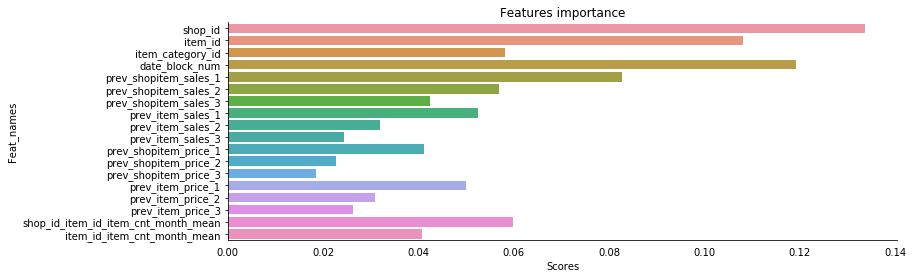

In [43]:
importance=pd.DataFrame(baseline_features[:-1], columns=["Feat_names"])
importance["Scores"]=model.feature_importances_
sns.barplot(data=importance, y="Feat_names", x="Scores", orient="h" )
plt.title("Features importance")
plt.tick_params(top='off', bottom='off', left='on', right='off', labelleft='on', labelbottom='on')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color("black")

## Select Features 

In [17]:
from sklearn.feature_selection import SelectFromModel
from numpy import sort

In [44]:
%%time
thresholds = sort(lgbm_model.feature_importances_)
for thresh in thresholds:
# select features using threshold
    selection = SelectFromModel(lgbm_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(trainx)
    # train model
    selection_model = lgbm.LGBMModel(objective="regression")
    selection_model.fit(select_X_train, trainy, eval_metric='rmse')
    # eval model
    select_X_test = selection.transform(valx)
    predictions =selection_model.predict(select_X_test)
    rmse = sqrt(mean_squared_error(valy, predictions))
    print("Thresh=%.3f, n=%d, RMSE: %.4f" % (thresh, select_X_train.shape[1], rmse))
  

Thresh=104.000, n=12, RMSE: 0.9384%
Thresh=111.000, n=11, RMSE: 0.9479%
Thresh=124.000, n=10, RMSE: 0.9425%
Thresh=133.000, n=9, RMSE: 0.9443%
Thresh=159.000, n=8, RMSE: 0.9460%
Thresh=245.000, n=7, RMSE: 0.9334%
Thresh=251.000, n=6, RMSE: 0.9364%
Thresh=301.000, n=5, RMSE: 0.9479%
Thresh=316.000, n=4, RMSE: 0.9693%
Thresh=337.000, n=3, RMSE: 0.9804%
Thresh=344.000, n=2, RMSE: 0.9872%
Thresh=575.000, n=1, RMSE: 1.0803%
Wall time: 3min 41s


In [25]:
%%time
lgbm_model=lgbm.LGBMModel(objective="regression", subsample=0.9, max_depth=8, learning_rate=0.05, 
                          n_estimators=500, random_state=12)
lgbm_model.fit(trainx, trainy, eval_metric="mse")

LGBMModel(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
     learning_rate=0.05, max_depth=8, min_child_samples=20,
     min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
     n_jobs=-1, num_leaves=31, objective='regression', random_state=12,
     reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.9,
     subsample_for_bin=200000, subsample_freq=0)

In [26]:
predictions=lgbm_model.predict(valx)

In [27]:
sqrt(mean_squared_error(valy, predictions))

0.7556967558659113

In [30]:
preds = lgbm_model.predict(testx)
    # Clipping to range 0-20
preds = np.clip(preds, 0,20)
#preds=[round(i,0) for i in preds]
df = pd.DataFrame(preds, columns = ['item_cnt_month'])
df['ID'] = df.index
df = df.set_index('ID')
df.to_csv('test_preds.csv')

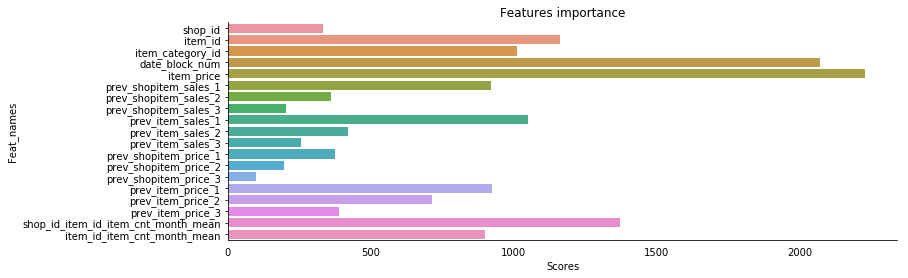

In [28]:

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

importance=pd.DataFrame(baseline_features[:-1], columns=["Feat_names"])
importance["Scores"]=lgbm_model.feature_importances_
sns.barplot(data=importance, y="Feat_names", x="Scores", orient="h" )
plt.title("Features importance")
plt.tick_params(top='off', bottom='off', left='on', right='off', labelleft='on', labelbottom='on')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color("black")

In [29]:

# Initialize data

# Initialize CatBoostRegressor
model_cat = CatBoostRegressor(iterations=200, learning_rate=0.3, depth=7)
# Fit model
model_cat.fit(trainx, trainy)
# Get predictions
preds_cat = model_cat.predict(valx)
sqrt(mean_squared_error(valy, preds_cat))

0:	learn: 1.0271661	total: 1.23s	remaining: 4m 3s
1:	learn: 0.8689909	total: 2.37s	remaining: 3m 54s
2:	learn: 0.7755643	total: 3.62s	remaining: 3m 57s
3:	learn: 0.7208431	total: 4.74s	remaining: 3m 52s
4:	learn: 0.6894995	total: 5.96s	remaining: 3m 52s
5:	learn: 0.6713396	total: 7.22s	remaining: 3m 53s
6:	learn: 0.6607087	total: 8.5s	remaining: 3m 54s
7:	learn: 0.6534876	total: 9.83s	remaining: 3m 56s
8:	learn: 0.6485649	total: 10.9s	remaining: 3m 51s
9:	learn: 0.6432853	total: 12.3s	remaining: 3m 52s
10:	learn: 0.6410097	total: 13.4s	remaining: 3m 50s
11:	learn: 0.6389663	total: 14.6s	remaining: 3m 48s
12:	learn: 0.6370893	total: 15.6s	remaining: 3m 44s
13:	learn: 0.6337267	total: 16.8s	remaining: 3m 43s
14:	learn: 0.6317135	total: 18.1s	remaining: 3m 42s
15:	learn: 0.6299725	total: 19.3s	remaining: 3m 42s
16:	learn: 0.6279922	total: 20.5s	remaining: 3m 41s
17:	learn: 0.6269726	total: 21.6s	remaining: 3m 37s
18:	learn: 0.6260310	total: 22.5s	remaining: 3m 34s
19:	learn: 0.6246008	tot

157:	learn: 0.5697904	total: 2m 56s	remaining: 46.8s
158:	learn: 0.5696921	total: 2m 57s	remaining: 45.7s
159:	learn: 0.5696610	total: 2m 58s	remaining: 44.6s
160:	learn: 0.5695516	total: 2m 59s	remaining: 43.4s
161:	learn: 0.5691207	total: 3m	remaining: 42.3s
162:	learn: 0.5690001	total: 3m 1s	remaining: 41.3s
163:	learn: 0.5688796	total: 3m 2s	remaining: 40.1s
164:	learn: 0.5687691	total: 3m 3s	remaining: 39s
165:	learn: 0.5681921	total: 3m 4s	remaining: 37.9s
166:	learn: 0.5677928	total: 3m 6s	remaining: 36.8s
167:	learn: 0.5677128	total: 3m 7s	remaining: 35.7s
168:	learn: 0.5675566	total: 3m 8s	remaining: 34.5s
169:	learn: 0.5674817	total: 3m 9s	remaining: 33.4s
170:	learn: 0.5674314	total: 3m 10s	remaining: 32.3s
171:	learn: 0.5673680	total: 3m 11s	remaining: 31.2s
172:	learn: 0.5672950	total: 3m 12s	remaining: 30s
173:	learn: 0.5672218	total: 3m 13s	remaining: 28.9s
174:	learn: 0.5671614	total: 3m 14s	remaining: 27.8s
175:	learn: 0.5668060	total: 3m 15s	remaining: 26.7s
176:	lear

0.7861111404489336

In [42]:
from sklearn.ensemble import RandomForestRegressor

ImportError: cannot import name 'RandomForest'